In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch
import pyvisa as visa
from rigol_osc import osc_ask_data
import tkinter as tk
from tkinter import filedialog
import csv
import time

In [16]:
# Dedault oscilloscope
sampling_time = 1 #s
memory_depth = "1M"
oscilloscope_address = 'TCPIP0::192.168.1.9::inst0::INSTR'
rm = visa.ResourceManager()
oscilloscope = rm.open_resource(oscilloscope_address)
print(oscilloscope.query('*IDN?'))
oscilloscope.chunk_size = 1024 * 1024
time.sleep(1)
oscilloscope.write(f':ACQ:MDEP {memory_depth}')
oscilloscope.write(f':TIMebase:MAIN:OFFSet {sampling_time/2}')
oscilloscope.write(f':TIMebase:MAIN:SCALe {sampling_time/10}')
oscilloscope.write(':SINGle')
# oscilloscope.close()
sampling_rate = int(float(oscilloscope.query(':ACQuire:SRATe?')))
print(f'Sampling rate: {sampling_rate/1000} kHz')

RIGOL TECHNOLOGIES,MSO5354,MS5A245109692,00.01.03.03.00

Sampling rate: 1000.0 kHz


In [17]:
oscilloscope.write(':TFORce')

9

In [18]:
# Get rawdata1
if oscilloscope.query(':TRIGger:STATus?') == 'STOP\n':
    rawdata1 = osc_ask_data([4], memory_depth, time_colume=False) #Squ

('TCPIP0::192.168.1.18::inst0::INSTR', 'TCPIP0::192.168.1.20::inst0::INSTR', 'TCPIP0::192.168.1.21::inst0::INSTR', 'TCPIP0::192.168.1.22::inst0::INSTR', 'TCPIP0::192.168.1.46::inst0::INSTR', 'TCPIP0::192.168.1.9::inst0::INSTR', 'TCPIP0::192.168.1.8::PSG::INSTR', 'GPIB0::18::INSTR')
RIGOL TECHNOLOGIES,MSO5354,MS5A245109692,00.01.03.03.00

Getting data from Channel 4...
OSC operation Done



In [6]:
# Get rawdata2
if oscilloscope.query(':TRIGger:STATus?') == 'STOP\n':
    rawdata2 = osc_ask_data([3], memory_depth, time_colume=False) #Antisqu

('TCPIP0::192.168.1.18::inst0::INSTR', 'TCPIP0::192.168.1.20::inst0::INSTR', 'TCPIP0::192.168.1.21::inst0::INSTR', 'TCPIP0::192.168.1.22::inst0::INSTR', 'TCPIP0::192.168.1.46::inst0::INSTR', 'TCPIP0::192.168.1.9::inst0::INSTR', 'TCPIP0::192.168.1.8::PSG::INSTR', 'GPIB0::18::INSTR')
RIGOL TECHNOLOGIES,MSO5354,MS5A245109692,00.01.03.03.00

Getting data from Channel 3...
OSC operation Done



In [11]:
# Get rawdata3
if oscilloscope.query(':TRIGger:STATus?') == 'STOP\n':
    rawdata3 = osc_ask_data([3], memory_depth, time_colume=False) #SNL

('TCPIP0::192.168.1.18::inst0::INSTR', 'TCPIP0::192.168.1.20::inst0::INSTR', 'TCPIP0::192.168.1.21::inst0::INSTR', 'TCPIP0::192.168.1.22::inst0::INSTR', 'TCPIP0::192.168.1.46::inst0::INSTR', 'TCPIP0::192.168.1.9::inst0::INSTR', 'TCPIP0::192.168.1.8::PSG::INSTR', 'GPIB0::18::INSTR')
RIGOL TECHNOLOGIES,MSO5354,MS5A245109692,00.01.03.03.00

Getting data from Channel 3...
OSC operation Done



In [19]:
rawdata2 = rawdata1
rawdata3 = rawdata1

In [20]:
# Read data
signal1 = rawdata1[0] #Squ
signal2 = rawdata2[0] #Antisqu
signal3 = rawdata3[0] #SNL

In [7]:
# Parameters
split_num = 1 # also is average number
window_seg_number = 2000 # number of segments in each window
# sampling_rate = 1000000 # Sa/s
zohms = 50

split_size = len(signal1) // split_num
signal1_split = np.array_split(signal1[:split_size*split_num], split_num)
signal2_split = np.array_split(signal2[:split_size*split_num], split_num)
signal3_split = np.array_split(signal3[:split_size*split_num], split_num)

# Welch's method for signal1
Pxx_avg_seg1 = []
for i in range(split_num):
    f1, Pxx_avg_seg1_ = welch(signal1_split[i], fs=sampling_rate, window='boxcar', nperseg=len(signal1_split[i])//window_seg_number, noverlap=None, scaling='spectrum')
    """
    window can be one of the following:
        - boxcar
        - triang
        - blackman
        - hamming
        - hann
        - bartlett
        - flattop
        - parzen
        - bohman
        - blackmanharris
        - nuttall
        - barthann
        - cosine
        - exponential
        - tukey
        - taylor
        - lanczos
    When window is boxcar, window_seg_number is 1, and noverlap is None, the result is equivalent to `scipy.signal.periodogram`.
    """
    Pxx_avg_seg1.append(Pxx_avg_seg1_)
Pxx_avg1 = np.mean(Pxx_avg_seg1, axis=0)
Pxx_avg1 = 10 * np.log10(Pxx_avg1 / zohms) + 30

# Welch's method for signal2
Pxx_avg_seg2 = []
for i in range(split_num):
    f2, Pxx_avg_seg2_ = welch(signal2_split[i], fs=sampling_rate, window='boxcar', nperseg=len(signal2_split[i])//window_seg_number, noverlap=None, scaling='spectrum')
    Pxx_avg_seg2.append(Pxx_avg_seg2_)
Pxx_avg2 = np.mean(Pxx_avg_seg2, axis=0)
Pxx_avg2 = 10 * np.log10(Pxx_avg2 / zohms) + 30

# Welch's method for signal3
Pxx_avg_seg3 = []
for i in range(split_num):
    f3, Pxx_avg_seg3_ = welch(signal3_split[i], fs=sampling_rate, window='boxcar', nperseg=len(signal3_split[i])//window_seg_number, noverlap=None, scaling='spectrum')
    Pxx_avg_seg3.append(Pxx_avg_seg3_)
Pxx_avg3 = np.mean(Pxx_avg_seg3, axis=0)
Pxx_avg3 = 10 * np.log10(Pxx_avg3 / zohms) + 30


Sampling rate: 1000.0 kHz


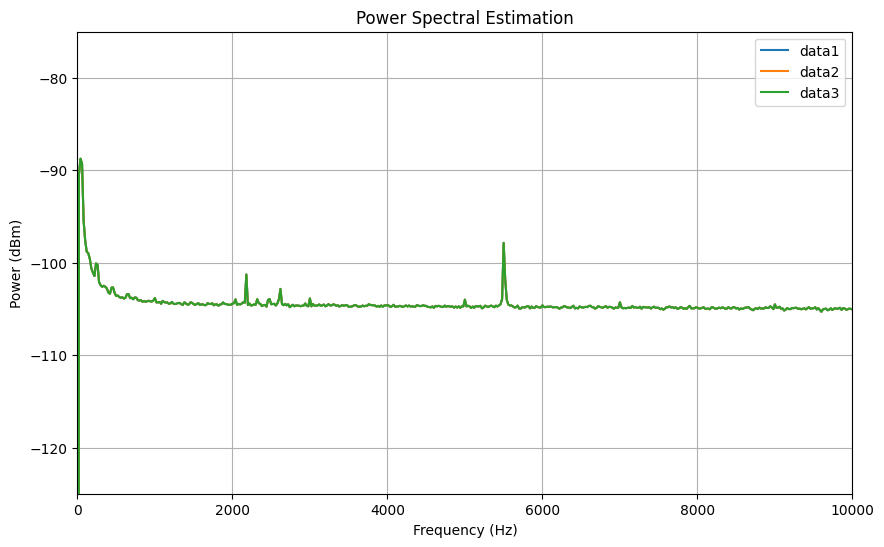

In [17]:
# Plot
print(f'Sampling rate: {sampling_rate/1000} kHz')
yrange = 50
yref = -100
plt.figure(figsize=(10, 6))
plt.plot(f1, Pxx_avg1, label='data1')
plt.plot(f2, Pxx_avg2, label='data2')
plt.plot(f3, Pxx_avg3, label='data3')
plt.title('Power Spectral Estimation')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power (dBm)')
plt.xlim(0,10000)
plt.ylim(yref-yrange/2, yref+yrange/2)
plt.legend()
plt.grid(True)
plt.show()


In [21]:
# Save data
file_name = 'test'
preamble = oscilloscope.query(':WAV:PRE?').split(',')
num_samples = int(preamble[2])
time_per_sample = float(preamble[4])
x_origin = float(preamble[5])
time_array = np.array([x_origin + i * time_per_sample for i in range(num_samples)])
final_data = [time_array]
final_data.append(signal1)
final_data.append(signal2)
final_data.append(signal3)
print('final_data generated. Choose a folder to save the data.')
if file_name:
    # choose a folder to save the data
    root = tk.Tk()
    root.withdraw()  # hide the root window
    folder_path = filedialog.askdirectory()
    # Save waveform data to a CSV file
    print('Writing CSV...')
    BUFFER_SIZE = 1000000  # Adjust the buffer size as needed
    with open(f'{folder_path}/{file_name}_.csv', 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(['Time'] + ['signal1'] + ['signal2'] + ['signal3'])  # Write header
        for row in zip(*final_data):  # Transpose and write
            writer.writerow(row)
    print('CSV writing Done')

final_data generated. Choose a folder to save the data.
Writing CSV...
CSV writing Done
